# Compare $W(k, k^{\prime}) \times P_{\mathrm{cubic}}(k^{\prime})$ and $P_{\mathrm{cutsky}}(k)$ to validate window computation

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import Profiles

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'

# mocks/version
catalog = 'second'
version = 'v3'
imocks = range(25)

# tracer
tracer = 'ELG_LOP'
region = 'SGC'
completeness = True
zrange = (1.1, 1.6)

# multipoles
ells = (0, 2, 4)
ktmax = 0.5
krange = (0.02, 0.2, 0.005)

# cut
rpcut = 0.
thetacut = 0.

## $P_{\mathrm{cubic}}(k)$

In [3]:
fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer)
cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

### Model fitted on $P_{\mathrm{cubic}}(k)$

In [4]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/'

template_name = 'shapefitqisoqap'

emulator_dir = os.path.join(data_dir, 'emulators/test/emulators_{}_ELG'.format(template_name))
profiles_dir = os.path.join(data_dir, 'profiles/cubicsecondgenmocks/profiles_{}_ELG_complete'.format(template_name))
profile_cubic = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors.npy'))

In [5]:
#likelihood = get_power_likelihood(data_type=data_type, tracer=tracer, region=region, completeness='complete_', solve=False, fc='', rp_cut=rp_cut, emulator_fn=os.path.join(emulator_dir.format('complete_'), '{}_{{}}.npy'.format(stat)))

#likelihood.solved_default = '.best'
#likelihood(**profile_cubic.bestfit.choice(input=True))
#box_obs = likelihood.observables[0]
#box_theory = box_obs.theory

## Window matrix $W(k, k^{\prime})$

In [6]:
from pypower import BaseMatrix

if source == 'desi':
    wm_fn = DESIFileName()
    wm_fn.set_default_config(version=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization='merged')
    koutrebin = 5
elif source == 'local':
    wm_fn = LocalFileName()
    wm_fn.set_default_config(mockgen=catalog, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization=None, boxsize=10000)
    wm_fn.update(cellsize=None)
    koutrebin = 1

wm = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut, zrange=zrange))

wm.slice_x(sliceout=slice(0, len(wm.xout[0]) // koutrebin * koutrebin, koutrebin))
wm.select_x(xoutlim=(krange[0], krange[1]))
kinrebin = 10
wm.slice_x(slicein=slice(0, len(wm.xin[0]) // kinrebin * kinrebin, kinrebin))
wm.select_x(xinlim=(0.005, ktmax))

In [7]:
wm_fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v3/complete/baseline_2pt/merged/pk/wmatrix_smooth_ELG_LOP_SGC_z1.1-1.6.npy'

### Theory from fitted $P_{\mathrm{cubic}}(k)$

In [8]:
from emulator_fit import get_fit_setup, get_template
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles

z, b0, klim, slim = get_fit_setup(tracer=tracer, theory_name='velocileptors')
for lim in klim.values():
    lim = krange
from cosmoprimo.fiducial import DESI
fiducial = DESI()
b1E = b0 / fiducial.growth_factor(z)

template = get_template(template_name=template_name, z=z)

theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, ells=klim.keys(), k=wm.xin[0])
pk_theory = theory(**profile_cubic.bestfit.choice(input=True))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20231013-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


### $W(k, k^{\prime}) \times P_{\mathrm{theory}}(k^{\prime})$

In [9]:
wm_pk = (wm.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))

## $P_{\mathrm{cutsky}}(k)$

In [10]:
if source == 'desi':
    fn = DESIFileName()
    fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness)
elif source == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen=catalog, tracer=tracer, region=region, completeness=completeness)
    fn.update(cellsize=6)
    
cutsky_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut, zrange=zrange) for imock in range(25)], xlim={ell: krange for ell in ells})

In [11]:
fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v3/complete/baseline_2pt/mock24/pk/pkpoles_ELG_LOP_SGC_z1.1-1.6.npy'

### Model fitted on $P_{\mathrm{cutsky}}(k)$

In [12]:
#data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/'

#template_name = 'shapefitqisoqap'

#if rpcut:
#    cutflag = '_rpcut{:.1f}'.format(rpcut)
#elif thetacut:
#    cutflag = '_thetacut{:.2f}'.format(thetacut)
#else:
#    cutflag = ''

#emulator_dir = os.path.join(data_dir, 'emulators/emulators_{}_ELG_LOP'.format(template_name))
#profiles_dir = os.path.join(data_dir, 'profiles/Y1secondgenmocks/profiles_{}_ELG_LOP_complete_SGC'.format(template_name))
#profile_cutsky = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors{}{}.npy'.format(cutflag, '_directedges' if cutflag else '')))

In [13]:
#from emulator_fit import get_power_likelihood

#likelihood = get_power_likelihood(source=source, catalog='second', tracer='ELG_LOP', region='SGC', completeness=True, solve=False, rp_cut=rpcut, theta_cut=thetacut, emulator_fn=os.path.join(emulator_dir.format('complete_'), 'power_{{}}.npy'))

#likelihood.solved_default = '.best'
#likelihood(**profile_cutsky.bestfit.choice(input=True))
#cutsky_obs = likelihood.observables[0]
#pk_obs = cutsky_obs.theory

### Y1 covariance

In [14]:
from cov_utils import truncate_cov
covdir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/pk/covariances/v0.1.5'
c1 = np.loadtxt(os.path.join(covdir, 'cov_gaussian_prerec_ELG_LOPnotqso_GCcomb_0.8_1.1.txt'))
c2 = np.loadtxt(os.path.join(covdir, 'cov_gaussian_prerec_ELG_LOPnotqso_GCcomb_1.1_1.6.txt'))
c1_trunc = truncate_cov(c1, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))
c2_trunc = truncate_cov(c2, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))
cov = np.linalg.inv(np.linalg.inv(c1_trunc) + np.linalg.inv(c2_trunc))
 
#from scipy.interpolate import interp1d
#stdY1 = interp1d(np.array((np.arange(0, 0.4, 0.005), )*3).flatten(), np.sqrt(np.diag(cov)), bounds_error=False)(cutsky_obs.k)
stdY1 = np.sqrt(np.diag(cov)).reshape((3, len(cov[0])//3))

In [15]:
new_krange = np.arange(0, 0.4, 0.005)
#masknew = np.logical_and(new_krange >= 0.02, new_krange < 0.2)
masknew = np.logical_and(new_krange >= krange[0], new_krange < krange[1])

In [16]:
len(stdY1[0])

36

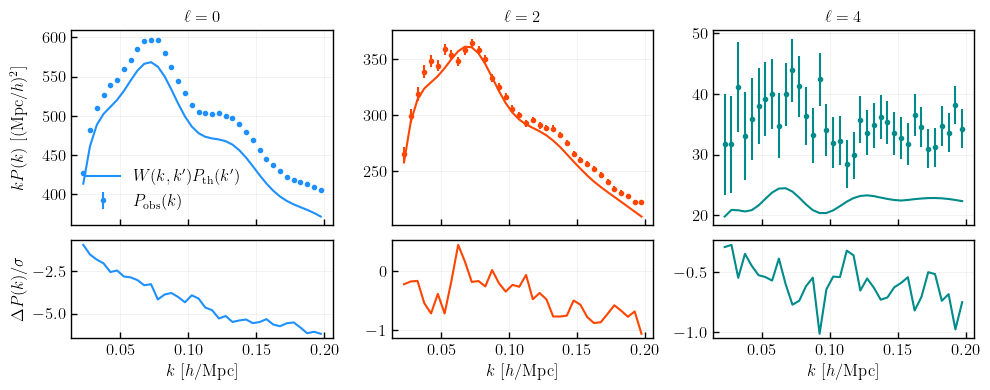

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].errorbar(cutsky_pk['k'][ill], cutsky_pk['k'][ill] * cutsky_pk['data'][ill], cutsky_pk['k'][ill]*stdY1[ill]/5, color='C{}'.format(ill), marker='.', ls='', label=r'$P_{\mathrm{obs}}(k)$')
    #axes[0][ill].plot(cutsky_obs.k[ill], cutsky_obs.k[ill] * cutsky_obs.theory[ill], color='C{:d}'.format(ill), linestyle='--', label=r'$P_{\mathrm{cutsky}}(k)$ fit')
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * wm_pk[ill], color='C{}'.format(ill), label=r'$W(k, k^{\prime}) P_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))
    
    axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] - cutsky_pk['data'][ill])/stdY1[ill], color='C{}'.format(ill))
    #axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] - cutsky_obs.theory[ill])/stdY1[ill], color='C{:d}'.format(ill), linestyle='--')
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P(k) / \sigma$')
axes[0][0].legend()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, version, 'window_validation_{}mocks{}_{}cut{:.2f}_{}_{}_ktmax{}.pdf'.format(len(imocks), '_complete' if completeness else '_fa', 'rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, ktmax)), dpi=200)
plt.show()

### compare v1 and v3

In [18]:
fn = LocalFileName()
fn.set_default_config(mockgen=catalog, tracer=tracer, region=region, completeness=completeness)
fn.update(cellsize=6)
local_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in range(25)], xlim={ell: krange for ell in ells})

fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness, weighting='_default_FKP')  
desi_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in range(25)], xlim={ell: krange for ell in ells})

FileNotFoundError: No such file or directory: /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v3/complete/baseline_2pt/mock0/pk/pkpoles_ELG_LOP_SGC_z0.8-1.6_default_FKP.npy

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False, sharex=True)

for ill, ell in enumerate(ells):
    axes[ill].plot(local_pk['k'][ill], local_pk['k'][ill] * local_pk['data'][ill], color='C{}'.format(ill), ls='--', label=r'v1')
    axes[ill].plot(desi_pk['k'][ill], desi_pk['k'][ill] * desi_pk['data'][ill], color='C{}'.format(ill), ls='-', label=r'v3')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlabel(r'$k$ [$h$/Mpc]')
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()